### Helpers

In [1]:
#Packages 
import pickle
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import json
import string
import nltk
from nltk.corpus import stopwords
from nltk import FreqDist, word_tokenize
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer

from textblob import TextBlob, Word
from wordcloud import WordCloud, ImageColorGenerator
import warnings
warnings.filterwarnings('ignore')
import re
from pylab import *

I will use the same functions from EDA notebook - I want to clean the data again before modeling

In [ ]:
# Functions for cleaning

In [2]:
#Define stopwords
punctuation = "".join([symbol for symbol in string.punctuation if symbol not in ["'", '"']])
punctuation += '–'
punctuation += '...'

stopwords_list = stopwords.words('english')
stopwords_list += list(punctuation)
stopwords_list += ['yeah','yea','uh','wo','yo','yeah!','ain\'t','i\'m','ah','ha','aa', 'aaah', 'aah', 
                   'aap','ab', 'abc','ac', 'aha', 'ahah','ahh ahh', 'ahha', 'ahhh',
                    'ahhhh', 'ahhhhh', 'ai','aight', 'aiight','aiyo', 'aiyyo', 'aj','aw','ay',
                   'aww', 'ayy','ayyo', 'ayyy', 'az', 'azz','\'em', 'em','haha','hahahahaha','hah','haa',
                   'hahah', 'hahaha', 'hahahah','one','ooh','oooh','oh','ooo','ot', 'otf', 'otha',
                    'qb','sh', 'sha', 'shabazz', 'shabba', 'shack','ugh',
                    'ughh', 'ugk', 'uhh','uhhh', 'uhhhh', 'uhhuh','uhm', 
                    'uhoh', 'uhuh','vv', 'vvs', 'wa','wit','woo','ya',
                    'yep','ym','yup','zro','yuh','jd', 'je','wow','ii', 'iii', 'it','ima',
                   'imma','jr', 'js','y\'all','y\'']

In [3]:
#Checking my list of stopwords
stopwords_list

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [4]:
#Function to have a list of words into one block
def concat_songs(list_lyrics):
    return ' '.join(lyric for lyric in list_lyrics)

In [5]:
def get_tokens(songs, remove_stop_words=True):
    """Splits a string of text into individual words and transform some bad languages"""
    #remove stop words
    stop_words = set(stopwords_list) if remove_stop_words else []
    #tokenize
    words = [x for x in songs.split() if x not in stop_words]
    words = ['Nword' if x in ['nigga', 'niggas','n*gga','n*ggas'] else x for x in words]
    words = ['Fword' if x in ['fuck', 'fucking','fuckin','fuckin\'','fucker','motherfucker','motherfucking','mothafuck', 
                              'mothafucka', 'mothafuckas', 'mothafucker', 'mothafuckers', 'mothafuckin', 'mothafucking',
                             'fuckers', 'motherfuck','mother fuckers','motherfuck', 'motherfucka', 'motherfuckas', 
                              'motherfucker','motherfuckers','motherfuckin','motherfucking'] else x for x in words]
    words = ['Bword' if x in ['bitch', 'bitch ', 'ho','hoes','b*tch','bitches', 'bitchin'] else x for x in words]
    return words

In [6]:
#replace in' with ing and digits - converting some rappers names back
def replace_contraction(list_lyrics):
    result = []
    for lyric in list_lyrics:
        lyric = re.sub(r'[0-9]', '# ',lyric)
        lyric = lyric.replace("# pac","2Pac")
        lyric = lyric.replace("# Pac","2Pac")
        lyric = lyric.replace("# chainz","2Chainz")
        lyric = lyric.replace("# Chainz","2Chainz")
        lyric = lyric.replace("# Savage","21Savage")
        lyric = lyric.replace("# Cent","50Cent")
        result.append(lyric.replace("in\'","ing"))
    return result

In [7]:
def lem_words(list_of_tokens,pos): 
    wrd_list = [Word(word).lemmatize(pos=pos) for word in list_of_tokens]
    # join the individual lemmas into a single string
    return wrd_list

In [8]:
#function to create wordcloud
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=17 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

In [9]:
#Function to create correlation heatmap - if necessary
def CorrMtx(df, dropDuplicates = True):

    # Exclude duplicate correlations by masking uper right values
    if dropDuplicates:    
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True

    # Set background color / chart style
    sns.set_style(style = 'white')

    # Set up  matplotlib figure
    f, ax = plt.subplots(figsize=(12, 8))

    # Add diverging colormap from red to blue
    cmap = sns.diverging_palette(250, 10, as_cmap=True)

    # Draw correlation plot with or without duplicates
    if dropDuplicates:
        sns.heatmap(df, mask=mask, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)
    else:
        sns.heatmap(df, cmap=cmap, 
                square=True,
                linewidth=.5, cbar_kws={"shrink": .5}, ax=ax)
        plt.xticks(rotation = 90)

## Getting dataframes & Cleaning

In [10]:
#Importing big dataframes
df = pd.read_pickle('../Data-Cleaning-EDA/cleaned_full_data.pkl')

In [11]:
print(df.shape) #(27109, 23)
df.head()

(27109, 23)


,Artist,Title,Album,duration_ms,popularity,num_markets,danceability,energy,loudness,speechiness,...,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,tokens,tokens_lemma,Count_words,Decade
0,DJ Jazzy Jeff & The Fresh Prince,Time to Chill,"He’s The DJ, I’m The Rapper",266040,24,79,0.735,0.559,-16.289,0.161,...,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,"[years, waitin, hesitatin, make, rap, record, ...","[year, waitin, hesitatin, make, rap, record, p...",234,1980-90s
1,Machine Gun Kelly,Candy,Hotel Diablo,156719,78,79,0.744,0.638,-4.860,0.049,...,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",165,2010-20s
2,Big Pun,You Ain’t a Killer,Capital Punishment,254866,57,79,0.724,0.887,-7.076,0.393,...,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,"[harsh, realities, life, taken, toll, even, je...","[harsh, reality, life, take, toll, even, jesus...",460,1990-00s
3,Das EFX,Buck-Buck,Hold It Down,193626,22,78,0.791,0.783,-10.470,0.416,...,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",316,1990-00s
4,Kool Moe Dee,To the Beat Y’all,Funke Funke Wisdom,201266,11,77,0.801,0.481,-13.903,0.232,...,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboy, old...",290,1990-00s


In [12]:
#drop some columns before re-cleaning the data
df = df.drop(columns=['Album','Title','duration_ms','tokens','tokens_lemma'])

In [13]:
df.shape #(27109, 18)

(27109, 18)

In [14]:
#Checking if any null values
df.isna().sum()

Artist                 0
popularity             0
num_markets            0
danceability           0
energy                 0
loudness               0
speechiness            0
acousticness           0
instrumentalness       0
liveness               0
valence                0
tempo                  0
time_signature         0
Year_release        5895
Cleaned_lyrics         0
duration_mins          0
Count_words            0
Decade                 0
dtype: int64

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27109 entries, 0 to 27513
Data columns (total 18 columns):
Artist              27109 non-null object
popularity          27109 non-null int64
num_markets         27109 non-null object
danceability        27109 non-null float64
energy              27109 non-null float64
loudness            27109 non-null float64
speechiness         27109 non-null float64
acousticness        27109 non-null float64
instrumentalness    27109 non-null float64
liveness            27109 non-null float64
valence             27109 non-null float64
tempo               27109 non-null float64
time_signature      27109 non-null object
Year_release        21214 non-null float64
Cleaned_lyrics      27109 non-null object
duration_mins       27109 non-null float64
Count_words         27109 non-null int64
Decade              27109 non-null object
dtypes: float64(11), int64(2), object(5)
memory usage: 3.9+ MB


In [16]:
#convert number of markets into int
df['num_markets'] = df['num_markets'].astype('int64')

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27109 entries, 0 to 27513
Data columns (total 18 columns):
Artist              27109 non-null object
popularity          27109 non-null int64
num_markets         27109 non-null int64
danceability        27109 non-null float64
energy              27109 non-null float64
loudness            27109 non-null float64
speechiness         27109 non-null float64
acousticness        27109 non-null float64
instrumentalness    27109 non-null float64
liveness            27109 non-null float64
valence             27109 non-null float64
tempo               27109 non-null float64
time_signature      27109 non-null object
Year_release        21214 non-null float64
Cleaned_lyrics      27109 non-null object
duration_mins       27109 non-null float64
Count_words         27109 non-null int64
Decade              27109 non-null object
dtypes: float64(11), int64(3), object(4)
memory usage: 3.9+ MB


In [115]:
df['Artist'] = df['Artist'].astype(str)

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27109 entries, 0 to 27513
Data columns (total 21 columns):
Artist               27109 non-null object
popularity           27109 non-null int64
num_markets          27109 non-null int64
danceability         27109 non-null float64
energy               27109 non-null float64
loudness             27109 non-null float64
speechiness          27109 non-null float64
acousticness         27109 non-null float64
instrumentalness     27109 non-null float64
liveness             27109 non-null float64
valence              27109 non-null float64
tempo                27109 non-null float64
time_signature       27109 non-null object
Year_release         21214 non-null float64
Cleaned_lyrics       27109 non-null object
duration_mins        27109 non-null float64
Count_words          27109 non-null int64
Decade               27109 non-null object
tokens               27109 non-null object
lemmatized_lyrics    27109 non-null object
working_lyrics       27

In [18]:
# get rid of lyrics with less than 25 words - should be taken care already
df.drop(df[df['Cleaned_lyrics'].str.len() < 25].index, inplace=True)

In [19]:
df.shape

(27109, 18)

In [20]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s


In [21]:
#remove stop words and create token
df['tokens'] = df.Cleaned_lyrics.apply(lambda x: get_tokens(x))

In [22]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, 14, know, Fword, going, know, keep, cand..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ..."


In [23]:
#more words cleaning
df['tokens'] = df.tokens.apply(lambda x: replace_contraction(x))

In [24]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, # # , know, Fword, going, know, keep, ca..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ..."


In [25]:
#Lemmatize for nouns
df['lemmatized_lyrics'] = df.tokens.apply(lambda x: lem_words(x,'n'))

In [26]:
#Lemmatize for verbs
df['lemmatized_lyrics'] = df.tokens.apply(lambda x: lem_words(x,'v'))

In [27]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens,lemmatized_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ..."
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy..."
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes..."
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g..."
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboys, ol..."


In [28]:
#updating count words columns
df['Count_words'] = df.lemmatized_lyrics.apply(lambda x: len(x))

In [29]:
df['working_lyrics'] = df.lemmatized_lyrics.apply(lambda x: concat_songs(x))

In [30]:
#Checking if there is null values after cleaning
df.isna().sum()

Artist                  0
popularity              0
num_markets             0
danceability            0
energy                  0
loudness                0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
time_signature          0
Year_release         5895
Cleaned_lyrics          0
duration_mins           0
Count_words             0
Decade                  0
tokens                  0
lemmatized_lyrics       0
working_lyrics          0
dtype: int64

In [31]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens,lemmatized_lyrics,working_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,...,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,...,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",big # # know Fword go know keep candy need li...
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,...,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,...,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,...,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboys, ol...",beat beat beat beat yes go homeboys old school...


## Most frequent words

### All Lyrics

In [ ]:
#Functions to count top words and plots the frequency (from https://github.com/h-parker/commencement-speech-generator/blob/master/nlp-eda.ipynb)

In [32]:
def get_top_n_words(ngram_start, ngram_end, corpus, n=10):
    """
    List the top n words in a vocabulary according to occurrence in corpus.
    """
    vec = CountVectorizer(ngram_range = (ngram_start, ngram_end))
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [33]:
def plot_top_n_ngrams(corpus, n, ngram_start, ngram_end):
    """
    Given corpus, number of top words you want, the range of 
    ngrams you're interested in (eg, just words: start = 1, end=1;
    words & bigrams: start=1, end=2), this function will graph the
    top words/ngrams in your corpus.
    """
    # get top n words
    top_words = get_top_n_words(ngram_start, ngram_end, corpus, n)
    
    # plot top n words
    fig = plt.figure(figsize=(10,6))
    ax = plt.barh([x[0] for x in top_words], [y[1] for y in top_words], 
            align='center', alpha=0.5,color='r')
    plt.title('Distribution of most frequent words')
    plt.xlabel('# times')
    plt.ylabel('Words')



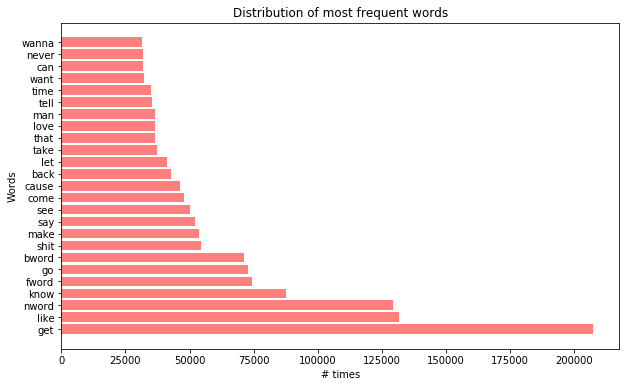

In [34]:
plot_top_n_ngrams(df.working_lyrics, 25, 1, 1)

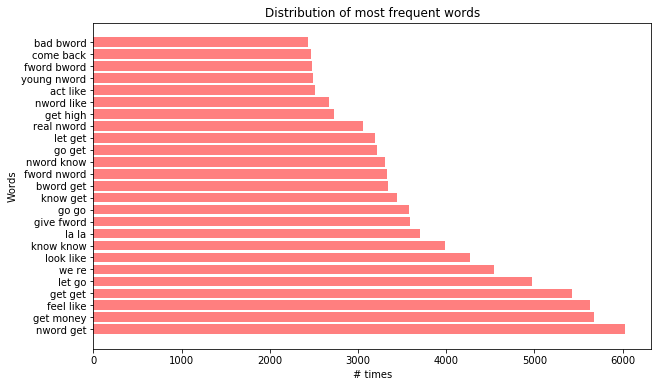

In [35]:
plot_top_n_ngrams(df.working_lyrics, 25, 2, 2)

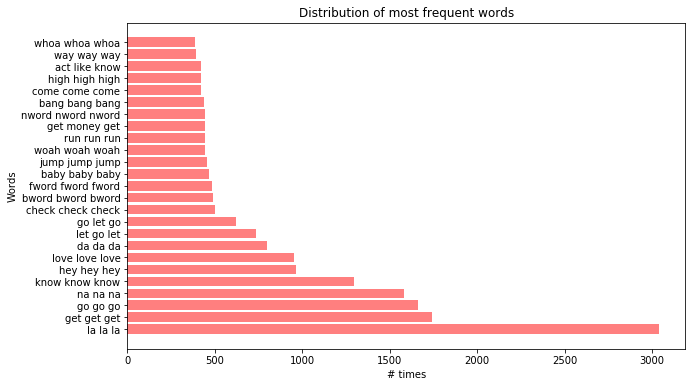

In [36]:
plot_top_n_ngrams(df.working_lyrics, 25, 3, 3)

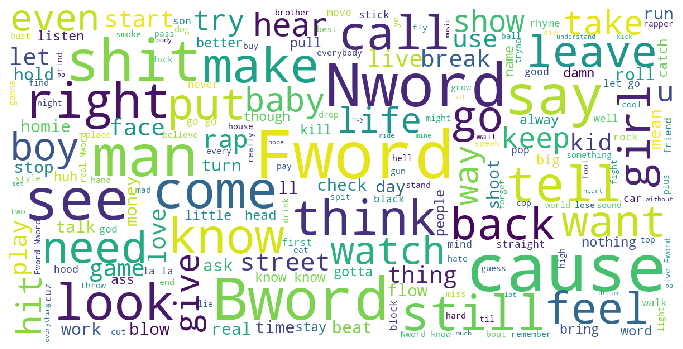

In [37]:
show_wordcloud(list(df.working_lyrics))

## Vector and Topic

In [84]:
df.columns

Index(['Artist', 'popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'Year_release',
       'Cleaned_lyrics', 'duration_mins', 'Count_words', 'Decade', 'tokens',
       'lemmatized_lyrics', 'working_lyrics'],
      dtype='object')

In [118]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import numpy as np

def display_topics(H, W, feature_names, documents, no_top_words, no_top_documents):
    for topic_idx, topic in enumerate(H):
        print("---------------------------")
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
        top_doc_indices = np.argsort( W[:,topic_idx] )[::-1][0:no_top_documents]
        for doc_index in top_doc_indices:
#             print (documents[doc_index])  
            print(str(df.Artist[doc_index]))  

In [131]:
documents = df.working_lyrics

no_features = 2000

# NMF is able to use tf-idf
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=25, max_features=no_features, stop_words=stopwords_list,ngram_range=(1, 3))
tfidf = tfidf_vectorizer.fit_transform(documents)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

# LDA can only use raw term counts for LDA because it is a probabilistic graphical model
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=25, max_features=no_features, stop_words=stopwords_list,ngram_range=(1, 3))
tf = tf_vectorizer.fit_transform(documents)
tf_feature_names = tf_vectorizer.get_feature_names()

no_topics = 5

# Run NMF
nmf_model = NMF(n_components=no_topics, random_state=17, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
nmf_W = nmf_model.transform(tfidf)
nmf_H = nmf_model.components_

# Run LDA
lda_model = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='batch', learning_offset=50.,random_state=0).fit(tf)
lda_W = lda_model.transform(tf)
lda_H = lda_model.components_

In [132]:
#Number of topic with Artist and titles
no_top_words = 25
no_top_documents = 5

In [133]:
#Have a look at the topics top words for NMF
display_topics(nmf_H, nmf_W, tfidf_feature_names, documents, no_top_words, no_top_documents)

---------------------------
Topic 0:
get like go make cause know see man come say time back never life take try think keep live let still look us people tell
Wyclef Jean
Queen Latifah
Too $hort
Three 6 Mafia
Onyx
---------------------------
Topic 1:
nword shit get nword get real know real nword nword know gon nword nword fword hood gun young shoot fword nword block young nword lil nword like talk bout streets die see
Machine Gun Kelly
Living Legends
Mac Miller
MC Lyte
Meek Mill
---------------------------
Topic 2:
bword get like money dick pussy ass bword get get money pimp bword bword smoke shit big go bad pull get bword hit bad bword lil bout call ball want
Eminem
Fat Joe
A$AP Rocky
Wiz Khalifa
Tech N9ne
---------------------------
Topic 3:
love baby girl know want wanna go say let feel need tell love love right good see hey think time know know give make way could night
E-40
Twista
Method Man
Tech N9ne
Kevin Gates
---------------------------
Topic 4:
fword shit fword fword give fwor

In [130]:
#Displaying topic for LDA
display_topics(lda_H, lda_W, tf_feature_names, documents, no_top_words, no_top_documents)

---------------------------
Topic 0:
nword fword bword get shit like know ass gon real go talk back say cause tell hit come pussy want give dick man nword get bout
Xzibit
Three 6 Mafia
Kool Keith
Danny Brown
N.O.R.E.
---------------------------
Topic 1:
get like money make go back big know bword see roll come keep new smoke game nword put cause hit man boy top look still
Snoop Dogg
Big K.R.I.T.
Snoop Dogg
A$AP Rocky
NF
---------------------------
Topic 2:
know go love baby let get girl want wanna tell need like way la say see make cause hey feel gotta know know give let go go go
MC Eiht
DMX
Pitbull
Everlast
G-Eazy
---------------------------
Topic 3:
get life see know never time make go like cause live say take think us come try still keep man tell god feel day world
Coolio
Bushwick Bill
Talib Kweli


KeyError: 803

In [ ]:
lda_categories = [lda_model_tfidf[bow_corpus[i]][0][0] for i in range(0, len(bow_corpus))]

## Vectorizing

### TF IDF

In [38]:
df.head()

,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens,lemmatized_lyrics,working_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,...,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,...,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",big # # know Fword go know keep candy need li...
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,...,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,...,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,...,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboys, ol...",beat beat beat beat yes go homeboys old school...


In [39]:
len(df) #27109

27109

after preparing the list of words - Let's get the words into vectors

In [40]:
#max_df --> ignore words that appear in 95% of the songs 
#ignores words that occur in fewer than 25 songs - use my created stopword list
# I am not interested in more than 1k features
vectorizer = TfidfVectorizer(max_df=0.95, max_features=2000,
                             min_df=25, stop_words=stopwords_list,
                             use_idf=True, ngram_range=(1, 3))

In [41]:
#using TF-IDF to vectorize 
lyrics_tfidf = vectorizer.fit_transform(df['working_lyrics'])

In [42]:
#Checking the shape of my TF-IDF vectorizer
print(lyrics_tfidf.shape) #(27109,1000)

(27109, 1000)


In [134]:
print(vectorizer.get_feature_names())

['act', 'act like', 'action', 'ahead', 'aim', 'air', 'album', 'alive', 'alone', 'along', 'already', 'alright', 'always', 'another', 'answer', 'anybody', 'anything', 'arm', 'around', 'ask', 'ass', 'ass nword', 'attention', 'away', 'aye', 'baby', 'baby baby', 'baby girl', 'back', 'bad', 'bad bword', 'bag', 'ball', 'band', 'bang', 'bang bang', 'bank', 'bar', 'battle', 'bear', 'beat', 'beautiful', 'become', 'bed', 'beef', 'begin', 'behind', 'believe', 'bend', 'benz', 'best', 'bet', 'better', 'big', 'bigger', 'bill', 'bird', 'bite', 'black', 'blame', 'blast', 'blaze', 'bleed', 'bless', 'blind', 'block', 'blood', 'blow', 'blue', 'blunt', 'body', 'bomb', 'bone', 'boo', 'book', 'boom', 'booty', 'boss', 'bottle', 'bottom', 'bounce', 'bout', 'bow', 'box', 'boy', 'boys', 'brain', 'brand', 'brand new', 'bread', 'break', 'breath', 'breathe', 'brick', 'bricks', 'bring', 'bro', 'brother', 'brothers', 'brown', 'buck', 'build', 'bullets', 'bullshit', 'bump', 'burn', 'bus', 'business', 'bust', 'buy', 'b

Transform TF-IDF vectors into a DataFrame

In [44]:
#TF-IDF vectorizer into DF
vect_df = pd.DataFrame(lyrics_tfidf.toarray(), columns=vectorizer.get_feature_names())

In [45]:
#Having a look - checking for length and null values
vect_df.sample(10)

,act,act like,action,ahead,aim,air,album,alive,alone,along,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
13541,0.000000,0.000000,0.0,0.0,0.0,0.137435,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.08081
14919,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000
11631,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.111296,0.0,0.039885,0.0,0.000000,0.000000,0.0,0.032290,0.0,0.00000
6844,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000
17806,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.455109,0.000000,0.0,0.000000,0.0,0.00000
13140,0.031161,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.033784,0.0,0.000000,0.0,0.000000,0.041277,0.0,0.000000,0.0,0.00000
1093,0.021173,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000
23116,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.069579,0.0,0.0,0.0,...,0.000000,0.0,0.055754,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000
2619,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.049428,0.000000,0.0,0.117345,0.0,0.00000
20647,0.225119,0.299053,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.00000


In [46]:
vect_df.shape #(27110, 1000)

(27109, 1000)

In [47]:
vect_df.isna().sum()

act            0
act like       0
action         0
ahead          0
aim            0
              ..
yet            0
york           0
young          0
young nword    0
zone           0
Length: 1000, dtype: int64

### Count Vector

In [64]:
count_vectorizer = CountVectorizer(max_df=0.9, max_features=1000,
                             min_df=25, stop_words=stopwords_list,
                             ngram_range=(1, 3))

In [65]:
#using counter to vectorize 
tf_vect = count_vectorizer.fit_transform(df['working_lyrics'])

In [67]:
#Checking the shape of my counter vectorizer
print(tf_vect.shape)

(27109, 1000)


In [69]:
tf_features = count_vectorizer.get_feature_names()

In [70]:
print(tf_features)

['act', 'act like', 'action', 'ahead', 'aim', 'air', 'album', 'alive', 'alone', 'along', 'already', 'alright', 'always', 'another', 'answer', 'anybody', 'anything', 'arm', 'around', 'ask', 'ass', 'ass nword', 'attention', 'away', 'aye', 'baby', 'baby baby', 'baby girl', 'back', 'bad', 'bad bword', 'bag', 'ball', 'band', 'bang', 'bang bang', 'bank', 'bar', 'battle', 'bear', 'beat', 'beautiful', 'become', 'bed', 'beef', 'begin', 'behind', 'believe', 'bend', 'benz', 'best', 'bet', 'better', 'big', 'bigger', 'bill', 'bird', 'bite', 'black', 'blame', 'blast', 'blaze', 'bleed', 'bless', 'blind', 'block', 'blood', 'blow', 'blue', 'blunt', 'body', 'bomb', 'bone', 'boo', 'book', 'boom', 'booty', 'boss', 'bottle', 'bottom', 'bounce', 'bout', 'bow', 'box', 'boy', 'boys', 'brain', 'brand', 'brand new', 'bread', 'break', 'breath', 'breathe', 'brick', 'bricks', 'bring', 'bro', 'brother', 'brothers', 'brown', 'buck', 'build', 'bullets', 'bullshit', 'bump', 'burn', 'bus', 'business', 'bust', 'buy', 'b

Create a DF with the features from counter vect

In [71]:
#Counter vectorizer into DF
tf_df = pd.DataFrame(tf_vect.toarray(), columns=tf_features)

In [72]:
tf_df.sample(10)

,act,act like,action,ahead,aim,air,album,alive,alone,along,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
21807,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
19531,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
17516,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
24448,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,0
7361,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
14963,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6138,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
18837,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20238,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


## Transformation SVD and LSA

In [50]:
from sklearn.decomposition import TruncatedSVD
from time import time
# init svd
print("Performing dimensionality reduction using LSA")
t0 = time()
    # Vectorizer results are normalized, which makes KMeans behave as
    # spherical k-means for better results. Since LSA/SVD results are
    # not normalized, we have to redo the normalization.
svd = TruncatedSVD(n_components=500, random_state=17)
lsa = make_pipeline(svd, Normalizer(copy=False))
# run svd
lyrics_lsa = lsa.fit_transform(lyrics_tfidf)
print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print("Explained variance of the SVD step: {}%".format(
int(explained_variance * 100)))

print()

Performing dimensionality reduction using LSA
done in 8.769636s
Explained variance of the SVD step: 75%



In [51]:
sum(svd.explained_variance_ratio_[0:500])

0.7520588263353238

In [52]:
lyrics_lsa.shape

(27109, 500)

In [ ]:
#Trying to understand the components

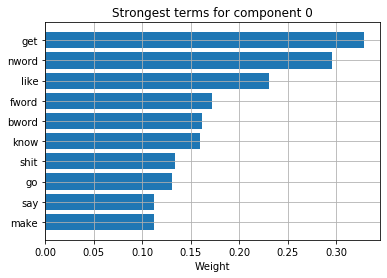

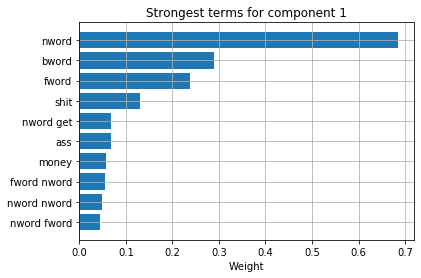

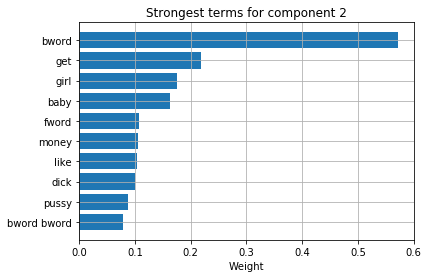

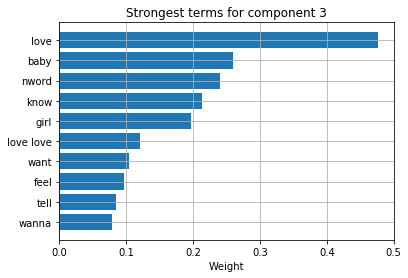

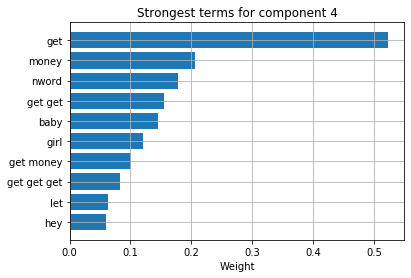

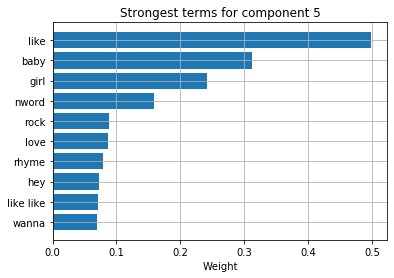

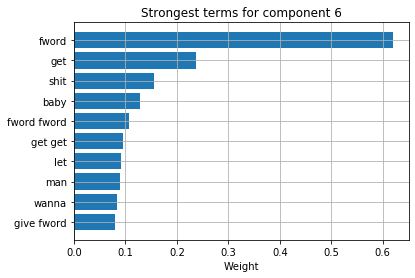

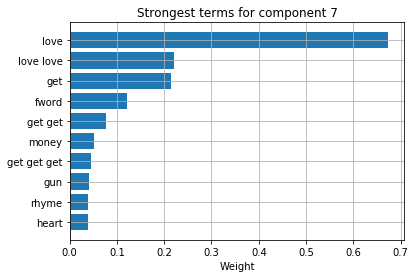

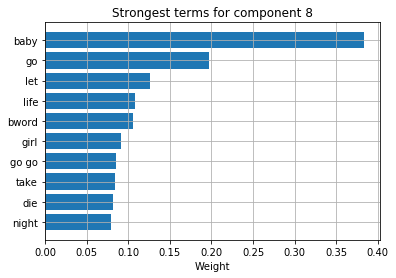

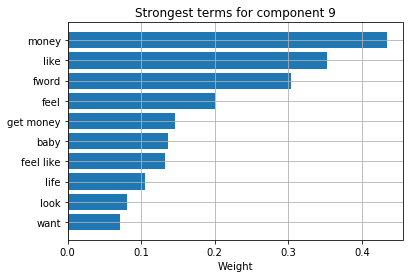

In [58]:
# taken from https://github.com/chrisjmccormick/LSA_Classification/blob/master/inspect_LSA.py
for compNum in range(0, 10):

    comp = svd.components_[compNum]
    feat_names = vectorizer.get_feature_names()
    
    # Sort the weights in the first component, and get the indeces
    indices = np.argsort(comp).tolist()
    
    # Reverse the indeces, so we have the largest weights first.
    indices.reverse()
    
    # Grab the top 10 terms which have the highest weight in this component.        
    terms = [feat_names[weightIndex] for weightIndex in indices[0:10]]    
    weights = [comp[weightIndex] for weightIndex in indices[0:10]]    
   
    # Display these terms and their weights as a horizontal bar graph.    
    # The horizontal bar graph displays the first item on the bottom; reverse
    # the order of the terms so the biggest one is on top.
    terms.reverse()
    weights.reverse()
    positions = arange(10) + .5    # the bar centers on the y axis
    
    figure(compNum)
    barh(positions, weights, align='center')
    yticks(positions, terms)
    xlabel('Weight')
    title('Strongest terms for component %d' % (compNum))
    grid(True)
    show()

## Latent dirichlet allocation

### from https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

### v1

In [62]:
import gensim
from gensim.models import LdaMulticore 
from gensim import corpora, models
from gensim.sklearn_api import TfIdfTransformer

# get all of the words in our corpus & create a bag of words
dictionary = gensim.corpora.Dictionary(df['lemmatized_lyrics'])
bow_corpus = [dictionary.doc2bow(doc) for doc in df['lemmatized_lyrics']]

# get the tf-idf (gensim-style, using their implementation of 
# sklearn's tf-idf model) of our data
model = TfIdfTransformer()
corpus_tfidf = model.fit_transform(bow_corpus)

# use LDA to get 10 topics to split up our descriptions into
lda_model_tfidf = LdaMulticore(corpus_tfidf, num_topics=5, id2word=dictionary, passes=2, workers=4)

for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.001*"Nword" + 0.000*"Bword" + 0.000*"Fword" + 0.000*"baby" + 0.000*"girl" + 0.000*"'cause" + 0.000*"love" + 0.000*"shit" + 0.000*"i’m" + 0.000*"man"
Topic: 1 Word: 0.003*"Nword" + 0.002*"Bword" + 0.002*"Fword" + 0.001*"money" + 0.001*"shit" + 0.001*"ass" + 0.001*"cause" + 0.001*"love" + 0.001*"baby" + 0.001*"wanna"
Topic: 2 Word: 0.002*"Nword" + 0.001*"love" + 0.001*"i’m" + 0.001*"Fword" + 0.001*"life" + 0.001*"feel" + 0.001*"never" + 0.001*"cause" + 0.001*"man" + 0.001*"baby"
Topic: 3 Word: 0.002*"Nword" + 0.002*"Bword" + 0.001*"i’m" + 0.001*"Fword" + 0.001*"baby" + 0.001*"money" + 0.001*"girl" + 0.001*"shit" + 0.001*"la" + 0.001*"love"
Topic: 4 Word: 0.001*"Nword" + 0.001*"Bword" + 0.000*"Fword" + 0.000*"love" + 0.000*"baby" + 0.000*"shit" + 0.000*"let" + 0.000*"girl" + 0.000*"feel" + 0.000*"want"


In [ ]:
for index, score in sorted(lda_model_tfidf[bow_corpus[1]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

In [ ]:
lda_categories = [lda_model_tfidf[bow_corpus[i]][0][0] for i in range(0, len(bow_corpus))]

In [ ]:
#Lyrics join(pd.Series(lda_categories))
lda_df = pd.concat([df, pd.Series(lda_categories, name='lda_category')], axis=1, join='outer')

In [ ]:
lda_df.isna().sum()

In [ ]:
lda_df.lda_category.value_counts()

In [ ]:
lda_df.head(25)

### v2

In [74]:
from sklearn.decomposition import LatentDirichletAllocation

In [76]:
# Run LDA for 10 topics
no_topics = 10
lda = LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', 
                                learning_offset=50.,random_state=0).fit(tf_vect)

In [ ]:
# Function to display the topic
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print "Topic %d:" % (topic_idx)
        print " ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]])

In [ ]:
# displaying the topic
no_top_words = 10
display_topics(lda, tf_feature_names, no_top_words)

## Clustering 1 - with LDA

In [165]:
# Required packages
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import datasets

In [ ]:
lda_df.columns

In [ ]:
features = lda_df[['popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature',
       'duration_mins', 'Count_words','lda_category']]

In [ ]:
features.head()

In [ ]:
#Covert columns in object to float
features['popularity'] = features['popularity'].astype('float64')

In [ ]:
features['num_markets'] = features['num_markets'].astype('float64')

In [ ]:
features.info()

In [ ]:
#Checking for null value due to topic attributes
features.isna().sum()

In [ ]:
features.dropna(inplace=True)

In [ ]:
features.isna().sum()

In [ ]:
len(features)

In [ ]:
#Create dummies variables
ts_dummies = pd.get_dummies(features['time_signature'], prefix='timsign', drop_first=True)
lda_dummies = pd.get_dummies(features['lda_category'], prefix='lda', drop_first=True)

In [ ]:
#Remove the original columns
features = features.drop(['time_signature','lda_category'], axis=1)

In [ ]:
features.head()

In [ ]:
features = pd.concat([features, ts_dummies, lda_dummies], axis=1)
features.head()

In [ ]:
#I forgot to scale my data - let's do it now
from sklearn.preprocessing import Normalizer, MinMaxScaler
norm = Normalizer()

In [ ]:
features_norm = pd.DataFrame(norm.fit_transform(features),columns=features.columns)

In [ ]:
features_norm.head()

### Elbow Method

In [ ]:
# Specifying the dataset and initializing variables
X = features_norm
distorsions = []

# Calculate SSE for different K
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('Number of clusters (k)')
plt.plot(range(2, 15), distorsions,'-o',color='black')
plt.grid(True)

### Silhouette coefficient

In [ ]:
# Generate silhouette coefficient for each k
X = features_norm
silhouette_plot = []
for k in range(2, 15):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

In [ ]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('Number of cluster - k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 15), silhouette_plot,'-o',color='black')
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [ ]:
model_1 = KMeans(n_clusters=4, random_state=10).fit(features_norm)
model_1.cluster_centers_

In [ ]:
cluster_labels = model_1.fit_predict(features_norm)

In [ ]:
len(cluster_labels)

In [ ]:
cluster_labels

In [ ]:
#Lyrics join
cluster_1_df = pd.concat([features, pd.Series(cluster_labels, name='cluster')], axis=1, join='outer')

In [ ]:
cluster_1_df.head()

In [ ]:
cluster_1_df.cluster.value_counts()

In [ ]:
##
cluster_1_df[cluster_1_df['cluster'] == 0]['duration_mins'].plot(kind='hist',color='r',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 1]['duration_mins'].plot(kind='hist',color='b',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 2]['duration_mins'].plot(kind='hist',color='grey',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 3]['duration_mins'].plot(kind='hist',color='black',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 4]['duration_mins'].plot(kind='hist',color='green',bins=50)
plt.title('Duration distribution per cluster')
plt.legend()
plt.show()

In [ ]:
cluster_1_df[cluster_1_df['cluster'] == 0]['Count_words'].plot(kind='hist',color='r',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 1]['Count_words'].plot(kind='hist',color='b',bins=50)
cluster_1_df[cluster_1_df['cluster'] == 2]['Count_words'].plot(kind='hist',color='black',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 3]['Count_words'].plot(kind='hist',color='grey',bins=50)
# cluster_1_df[cluster_1_df['cluster'] == 4]['Count_words'].plot(kind='hist',color='green',bins=50)
plt.title('Count words per cluster')
plt.legend()
plt.show()

## Clustering 2 - with TFIDF

### Preparation

In [135]:
print(vect_df.shape)
vect_df.head()

(27109, 1000)


,act,act like,action,ahead,aim,air,album,alive,alone,along,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000,...,0.0,0.0,0.077285,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.093323,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.038533,0.0,0.228884,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.423628,0.0,0.000000,0.0,0.0000,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.053319,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0546,...,0.0,0.0,0.000000,0.0,0.082255,0.0,0.000000,0.0,0.0,0.0


In [136]:
print(df.shape)
df.head()

(27109, 21)


,Artist,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,...,tempo,time_signature,Year_release,Cleaned_lyrics,duration_mins,Count_words,Decade,tokens,lemmatized_lyrics,working_lyrics
0,DJ Jazzy Jeff & The Fresh Prince,24,79,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,...,170.385,4,1988.0,for years i have been waitin and hesitatin to ...,4.43,234,1980-90s,"[years, waitin, hesitatin, make, rap, record, ...","[years, waitin, hesitatin, make, rap, record, ...",years waitin hesitatin make rap record pace sl...
1,Machine Gun Kelly,78,79,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,...,98.019,4,2019.0,haha big 14 you know what the fuck going on ...,2.61,165,2010-20s,"[big, # # , know, Fword, going, know, keep, ca...","[big, # # , know, Fword, go, know, keep, candy...",big # # know Fword go know keep candy need li...
2,Big Pun,57,79,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,...,90.945,4,1998.0,the harsh realities of life have taken toll ev...,4.25,460,1990-00s,"[harsh, realities, life, taken, toll, even, je...","[harsh, realities, life, take, toll, even, jes...",harsh realities life take toll even jesus chri...
3,Das EFX,22,78,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,...,95.677,4,1995.0,skoob and dray giving shoutouts chorus well ...,3.23,316,1990-00s,"[skoob, dray, giving, shoutouts, chorus, well,...","[skoob, dray, give, shoutouts, chorus, well, g...",skoob dray give shoutouts chorus well give buc...
4,Kool Moe Dee,11,77,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,...,108.597,4,1991.0,to the beat to the beat y'all to the beat y'a...,3.35,290,1990-00s,"[beat, beat, beat, beat, yes, goes, homeboys, ...","[beat, beat, beat, beat, yes, go, homeboys, ol...",beat beat beat beat yes go homeboys old school...


In [137]:
df.columns

Index(['Artist', 'popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'Year_release',
       'Cleaned_lyrics', 'duration_mins', 'Count_words', 'Decade', 'tokens',
       'lemmatized_lyrics', 'working_lyrics'],
      dtype='object')

In [140]:
#Keep the columns I will use for clustering
df_short = df[['popularity', 'num_markets', 'danceability', 'energy',
       'loudness', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo',
       'duration_mins', 'Count_words']]

In [141]:
df_short.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27109 entries, 0 to 27513
Data columns (total 13 columns):
popularity          27109 non-null int64
num_markets         27109 non-null int64
danceability        27109 non-null float64
energy              27109 non-null float64
loudness            27109 non-null float64
speechiness         27109 non-null float64
acousticness        27109 non-null float64
instrumentalness    27109 non-null float64
liveness            27109 non-null float64
valence             27109 non-null float64
tempo               27109 non-null float64
duration_mins       27109 non-null float64
Count_words         27109 non-null int64
dtypes: float64(10), int64(3)
memory usage: 4.1 MB


In [142]:
df_short.isna().sum()

popularity          0
num_markets         0
danceability        0
energy              0
loudness            0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
duration_mins       0
Count_words         0
dtype: int64

In [155]:
#Concat the features with tf-idf
data_tfidf = pd.concat([df_short, vect_df], axis=1)
data_tfidf.tail()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
27509,68.0,79.0,0.743,0.660,-4.802,0.418,0.1150,0.000000,0.101,0.549,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27510,32.0,79.0,0.686,0.420,-16.039,0.292,0.1370,0.000000,0.120,0.320,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27511,61.0,79.0,0.551,0.609,-8.975,0.143,0.3680,0.000154,0.192,0.324,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27512,32.0,79.0,0.671,0.889,-4.269,0.295,0.2680,0.000349,0.216,0.747,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
27513,10.0,1.0,0.371,0.957,-3.475,0.382,0.0736,0.000000,0.743,0.627,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [154]:
data_tfidf.shape

(27510, 1013)

In [156]:
#Checking for null values
data_tfidf.isna().sum()

popularity      401
num_markets     401
danceability    401
energy          401
loudness        401
               ... 
yet             401
york            401
young           401
young nword     401
zone            401
Length: 1013, dtype: int64

In [157]:
#Dropp
data_tfidf.fillna(value=0,inplace=True)

In [158]:
data_tfidf.shape

(27510, 1013)

In [159]:
#Checking for null values
data_tfidf.isna().sum()

popularity      0
num_markets     0
danceability    0
energy          0
loudness        0
               ..
yet             0
york            0
young           0
young nword     0
zone            0
Length: 1013, dtype: int64

In [161]:
from sklearn.preprocessing import StandardScaler
norm = StandardScaler()

In [162]:
#Scaling data
data_tfidf_norm = pd.DataFrame(norm.fit_transform(data_tfidf),columns=data_tfidf.columns)

In [163]:
data_tfidf_norm.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
0,-0.321125,0.464729,0.359164,-0.692812,-2.996303,-0.603833,-0.797476,-0.150334,-0.914008,1.649194,...,-0.271141,-0.221757,2.779213,-0.130686,-0.216998,-0.208401,-0.170933,-0.321195,-0.151176,-0.164108
1,2.644479,0.464729,0.414200,-0.251169,0.643409,-1.346421,-0.763297,-0.150556,-0.270692,-0.194294,...,-0.271141,-0.221757,-0.266310,-0.130686,-0.216998,-0.208401,-0.170933,-0.321195,-0.151176,-0.164108
2,1.491189,0.464729,0.291898,1.140843,-0.062305,0.934385,-0.109316,-0.150556,-0.654925,1.006011,...,-0.271141,-0.221757,-0.266310,-0.130686,0.817642,-0.208401,8.513157,-0.321195,-0.151176,-0.164108
3,-0.430962,0.424351,0.701610,0.559441,-1.143168,1.086880,0.717849,-0.150556,0.349570,0.036708,...,-0.271141,-0.221757,-0.266310,-0.130686,-0.216998,-0.208401,-0.170933,-0.321195,-0.151176,-0.164108
4,-1.035067,0.383974,0.762761,-1.128864,-2.236450,-0.133085,-0.706020,-0.149350,0.898475,0.249592,...,-0.271141,-0.221757,-0.266310,-0.130686,1.991630,-0.208401,-0.170933,-0.321195,-0.151176,-0.164108


### Let's cluster

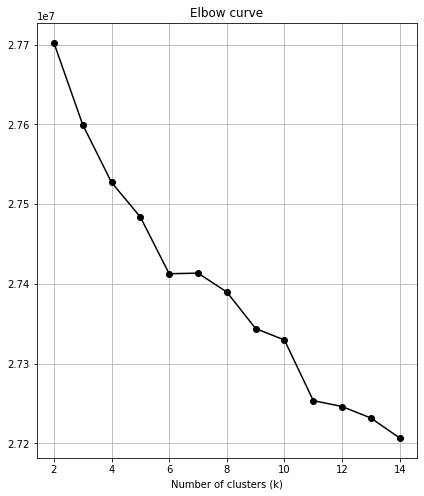

In [166]:
#Elbow
# Specifying the dataset and initializing variables
X = data_tfidf_norm
distorsions = []

# Calculate SSE for different K
for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state = 301)
    kmeans.fit(X)
    distorsions.append(kmeans.inertia_)

# Plot values of SSE
plt.figure(figsize=(15,8))
plt.subplot(121, title='Elbow curve')
plt.xlabel('Number of clusters (k)')
plt.plot(range(2, 15), distorsions,'-o',color='black')
plt.grid(True)

In [167]:
#Silhouette
# Generate silhouette coefficient for each k
X = data_tfidf_norm
silhouette_plot = []
for k in range(2, 15):
    clusters = KMeans(n_clusters=k, random_state=10)
    cluster_labels = clusters.fit_predict(X)
    silhouette_avg = metrics.silhouette_score(X, cluster_labels)
    silhouette_plot.append(silhouette_avg)

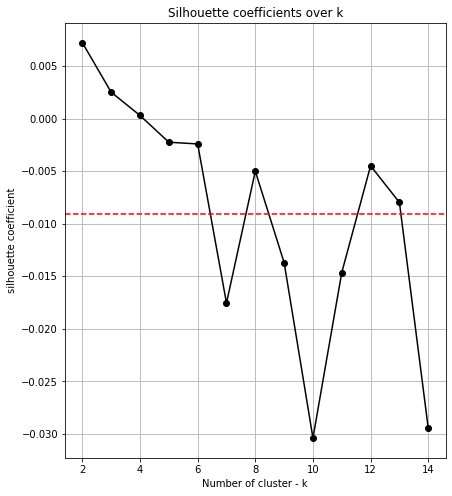

In [168]:
# Plot Silhouette coefficient
plt.figure(figsize=(15,8))
plt.subplot(121, title='Silhouette coefficients over k')
plt.xlabel('Number of cluster - k')
plt.ylabel('silhouette coefficient')
plt.plot(range(2, 15), silhouette_plot,'-o',color='black')
plt.axhline(y=np.mean(silhouette_plot), color="red", linestyle="--")
plt.grid(True)

In [169]:
model_2 = KMeans(n_clusters=6, random_state=10).fit(data_tfidf_norm)
model_2.cluster_centers_

array([[-0.01467366,  0.00386057, -0.01214144, ...,  0.07095326,
         0.02125076,  0.01517981],
       [ 0.02171279, -0.0018152 , -0.00750425, ...,  0.26931959,
         0.40569013,  0.01968181],
       [-0.03651766, -0.01868751, -0.0066835 , ..., -0.09391224,
        -0.12049722, -0.00188224],
       [ 0.00865259, -0.02012886,  0.02095086, ..., -0.10060441,
        -0.14076034,  0.09893108],
       [ 0.01043088, -0.00343327, -0.00885813, ...,  0.01484982,
        -0.08371758, -0.00525009],
       [ 0.00863458,  0.02580795,  0.0175306 , ..., -0.16396075,
        -0.10521714, -0.07589989]])

In [170]:
cluster_2_labels = model_2.fit_predict(data_tfidf_norm)

In [171]:
#Lyrics join
cluster_2_df = pd.concat([data_tfidf, pd.Series(cluster_2_labels, name='cluster')], axis=1, join='outer')


In [172]:
cluster_2_df.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,year,years,yellow,yes,yet,york,young,young nword,zone,cluster
0,24.0,79.0,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,...,0.0,0.077285,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,3.0
1,78.0,79.0,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,5.0
2,57.0,79.0,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,...,0.0,0.000000,0.0,0.038533,0.0,0.228884,0.0,0.0,0.0,4.0
3,22.0,78.0,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,3.0
4,11.0,77.0,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,...,0.0,0.000000,0.0,0.082255,0.0,0.000000,0.0,0.0,0.0,3.0


In [173]:
cluster_2_df.shape

(27514, 1014)

In [174]:
cluster_2_df.cluster.value_counts()

5.0    5756
4.0    4916
0.0    4875
1.0    4595
2.0    4272
3.0    3096
Name: cluster, dtype: int64

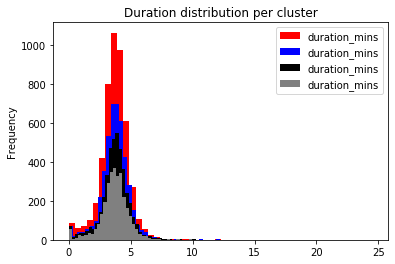

In [179]:
##
cluster_2_df[cluster_2_df['cluster'] == 0]['duration_mins'].plot(kind='hist',color='r',bins=50)
cluster_2_df[cluster_2_df['cluster'] == 1]['duration_mins'].plot(kind='hist',color='b',bins=50)
cluster_2_df[cluster_2_df['cluster'] == 2]['duration_mins'].plot(kind='hist',color='black',bins=50)
cluster_2_df[cluster_2_df['cluster'] == 3]['duration_mins'].plot(kind='hist',color='grey',bins=50)
# cluster_2_df[cluster_2_df['cluster'] == 4]['duration_mins'].plot(kind='hist',color='green',bins=50)
# cluster_2_df[cluster_2_df['cluster'] == 5]['duration_mins'].plot(kind='hist',color='steelblue',bins=50)
plt.title('Duration distribution per cluster')
plt.legend()
plt.show()

In [ ]:
#PCA for visualization

In [185]:
cluster_2_df.dropna(inplace=True)

In [186]:
test = cluster_2_df.drop(columns=['cluster'])

In [187]:
len(test)

27506

In [188]:
test.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
0,24.0,79.0,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,...,0.0,0.0,0.077285,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,78.0,79.0,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
2,57.0,79.0,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,...,0.0,0.0,0.000000,0.0,0.038533,0.0,0.228884,0.0,0.0,0.0
3,22.0,78.0,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,11.0,77.0,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,...,0.0,0.0,0.000000,0.0,0.082255,0.0,0.000000,0.0,0.0,0.0


In [189]:
len(cluster_2_df)

27506

In [190]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_new = pca.fit_transform(test)
x,y = zip(*X_new)
cluster_2_df['x'] = x
cluster_2_df['y'] = y
components = pca.components_
explained_variance = pca.explained_variance_
explained_variance_ratio = pca.explained_variance_ratio_
singular_values = pca.singular_values_

In [191]:
explained_variance_ratio

array([0.86326437, 0.07760868])

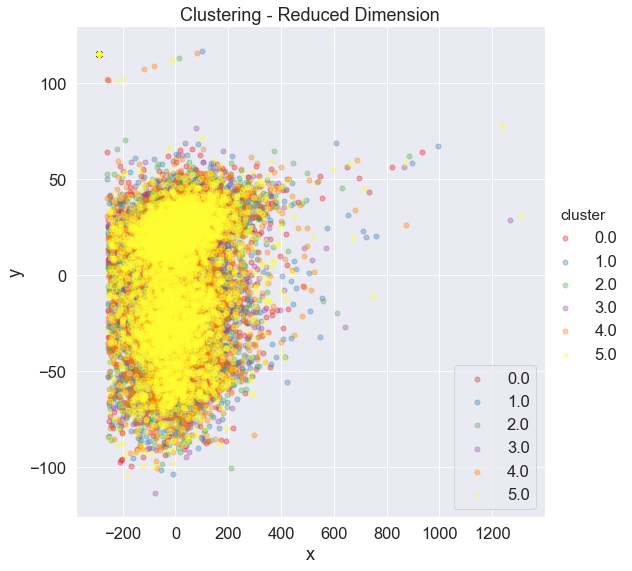

In [192]:
sns.set(font_scale=1.5)
sns.lmplot(data=cluster_2_df, x='x', y='y', hue='cluster', fit_reg=False, legend=True, size=8, palette='Set1',
           scatter_kws={'alpha':0.35, 's':25})
plt.legend(loc='lower right')
# plt.ylim(-0.7,1.8)
# plt.xlim(-0.7,1.8)
# plt.savefig('pca_scatter_genres.png')
plt.title("Clustering - Reduced Dimension")
plt.show()

In [193]:
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

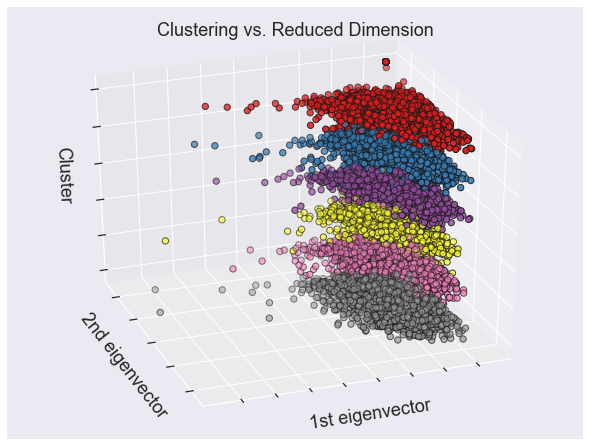

In [194]:
#Visualize top 3 components
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(cluster_2_df['x'], cluster_2_df['y'], cluster_2_df['cluster'], c=cluster_2_df['cluster'],
           cmap=plt.cm.Set1, edgecolor='k', s=40)

ax.set_title('Clustering vs. Reduced Dimension')
ax.set_xlabel("1st eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("Cluster")
ax.w_zaxis.set_ticklabels([])

plt.show()

In [195]:
cluster_2_df.head()

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,yellow,yes,yet,york,young,young nword,zone,cluster,x,y
0,24.0,79.0,0.735,0.559,-16.289,0.161,0.00172,0.000020,0.0648,0.887,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,3.0,-46.147971,-58.629900
1,78.0,79.0,0.744,0.638,-4.860,0.049,0.00829,0.000000,0.1820,0.480,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,5.0,-116.231876,3.781163
2,57.0,79.0,0.724,0.887,-7.076,0.393,0.13400,0.000000,0.1120,0.745,...,0.0,0.038533,0.0,0.228884,0.0,0.0,0.0,4.0,177.581130,25.151640
3,22.0,78.0,0.791,0.783,-10.470,0.416,0.29300,0.000000,0.2950,0.531,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,3.0,32.947604,18.176981
4,11.0,77.0,0.801,0.481,-13.903,0.232,0.01930,0.000107,0.3950,0.578,...,0.0,0.082255,0.0,0.000000,0.0,0.0,0.0,3.0,7.129029,5.739891


In [196]:
list(cluster_2_df.columns)

['popularity',
 'num_markets',
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_mins',
 'Count_words',
 'act',
 'act like',
 'action',
 'ahead',
 'aim',
 'air',
 'album',
 'alive',
 'alone',
 'along',
 'already',
 'alright',
 'always',
 'another',
 'answer',
 'anybody',
 'anything',
 'arm',
 'around',
 'ask',
 'ass',
 'ass nword',
 'attention',
 'away',
 'aye',
 'baby',
 'baby baby',
 'baby girl',
 'back',
 'bad',
 'bad bword',
 'bag',
 'ball',
 'band',
 'bang',
 'bang bang',
 'bank',
 'bar',
 'battle',
 'bear',
 'beat',
 'beautiful',
 'become',
 'bed',
 'beef',
 'begin',
 'behind',
 'believe',
 'bend',
 'benz',
 'best',
 'bet',
 'better',
 'big',
 'bigger',
 'bill',
 'bird',
 'bite',
 'black',
 'blame',
 'blast',
 'blaze',
 'bleed',
 'bless',
 'blind',
 'block',
 'blood',
 'blow',
 'blue',
 'blunt',
 'body',
 'bomb',
 'bone',
 'boo',
 'book',
 'boom',
 'booty',
 'boss',
 'bottle',
 'bottom',
 '

In [197]:
cluster_centers = pd.DataFrame(model_2.cluster_centers_,columns=test.columns)

In [198]:
cluster_centers

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,...,wrong,year,years,yellow,yes,yet,york,young,young nword,zone
0,-0.014674,0.003861,-0.012141,0.007668,0.011339,0.009316,0.016186,-0.009534,0.027737,-0.000090,...,0.012994,0.020054,0.022911,-0.006811,-0.063077,-0.006580,0.076285,0.070953,0.021251,0.015180
1,0.021713,-0.001815,-0.007504,0.009870,0.006298,0.005098,-0.012998,-0.010194,0.000758,-0.004268,...,-0.128319,-0.051674,-0.138103,0.172439,-0.092542,-0.081760,-0.103996,0.269320,0.405690,0.019682
2,-0.036518,-0.018688,-0.006683,-0.002654,-0.007044,0.004843,-0.016176,0.000323,0.014964,0.006179,...,0.090723,-0.064832,-0.140072,-0.031149,0.045986,-0.024767,-0.069013,-0.093912,-0.120497,-0.001882
3,0.008653,-0.020129,0.020951,-0.013561,0.014512,-0.045959,-0.016020,0.003686,-0.004301,-0.038088,...,-0.034431,0.167834,0.149324,-0.010694,0.176931,0.146200,0.338578,-0.100604,-0.140760,0.098931
4,0.010431,-0.003433,-0.008858,0.005505,0.008647,0.005097,-0.001219,0.019008,-0.011989,0.011018,...,0.214993,0.101324,0.314824,-0.062440,0.004683,0.149367,-0.064498,0.014850,-0.083718,-0.005250
5,0.008635,0.025808,0.017531,-0.009812,-0.024594,0.004813,0.018330,-0.002244,-0.022650,0.009973,...,-0.140999,-0.104427,-0.154395,-0.049691,-0.005997,-0.116983,-0.057396,-0.163961,-0.105217,-0.075900


In [200]:
cluster_summary_c = cluster_centers[['popularity','num_markets',
                'danceability','energy', 'loudness',
       'speechiness', 'acousticness', 'instrumentalness','liveness',
       'valence','tempo','duration_mins','Count_words']]

In [201]:
cluster_summary_c.head(10)

,popularity,num_markets,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins,Count_words
0,-0.014674,0.003861,-0.012141,0.007668,0.011339,0.009316,0.016186,-0.009534,0.027737,-0.000090,-0.017790,-0.018575,-0.017987
1,0.021713,-0.001815,-0.007504,0.009870,0.006298,0.005098,-0.012998,-0.010194,0.000758,-0.004268,0.004049,0.008281,0.003481
2,-0.036518,-0.018688,-0.006683,-0.002654,-0.007044,0.004843,-0.016176,0.000323,0.014964,0.006179,-0.029050,-0.000327,-0.020669
3,0.008653,-0.020129,0.020951,-0.013561,0.014512,-0.045959,-0.016020,0.003686,-0.004301,-0.038088,-0.010467,-0.014944,-0.012903
4,0.010431,-0.003433,-0.008858,0.005505,0.008647,0.005097,-0.001219,0.019008,-0.011989,0.011018,0.022007,0.010306,0.024373
5,0.008635,0.025808,0.017531,-0.009812,-0.024594,0.004813,0.018330,-0.002244,-0.022650,0.009973,0.020230,0.008600,0.013919


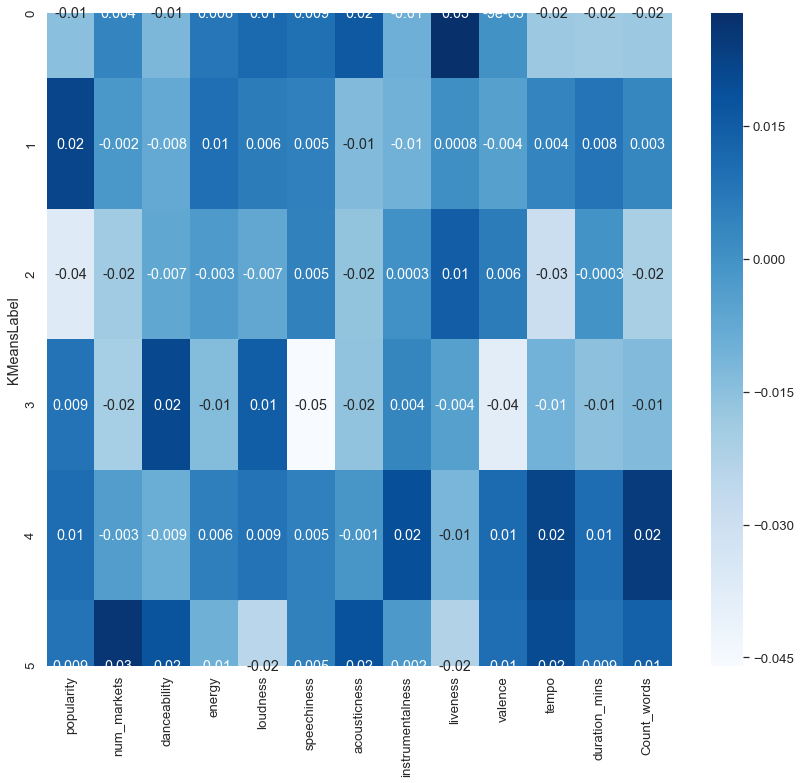

In [206]:
plt.figure(figsize=(14,12))
sns.set(font_scale=1.2)

sns.heatmap(
    data=cluster_summary_c,
    annot=True,cmap = "Blues",fmt='.1g',square=False
)
plt.ylabel("KMeansLabel")
plt.show()

In [207]:
test.shape

(27506, 1013)

In [208]:
cluster_2_df.shape

(27506, 1016)

In [ ]:
#evaluation

In [ ]:
>>> kmeans_model = KMeans(n_clusters=4, random_state=17).fit(data_tfidf_norm)
>>> labels = kmeans_model.labels_
>>> metrics.silhouette_score(X, labels, metric='euclidean')

In [ ]:
# k=4 --- sil = 

In [ ]:
#Calinski-Harabasz Index
>>> import numpy as np
>>> from sklearn.cluster import KMeans
>>> kmeans_model = KMeans(n_clusters=3, random_state=1).fit(X)
>>> labels = kmeans_model.labels_
>>> metrics.calinski_harabasz_score(X, labels)  
561.62...

In [211]:
>>> from sklearn.cluster import AgglomerativeClustering
>>> import numpy as np
>>> X = data_tfidf_norm
>>> clustering = AgglomerativeClustering().fit(X)
>>> clustering 
AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=6,
                        pooling_func='deprecated')


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=6,
                        pooling_func='deprecated')

In [212]:
>>> clustering.labels_

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
## Clusters artist

In [ ]:

#open data frame
with open('../Data-Cleaning-EDA/cleaned_year_data.pkl', 'wb') as file:
    pickle.dump(year_df, file)